In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/lejohntanjunyen/Documents/Pattern_Recognition/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Extract and Load Data

In [2]:
annotation_file_path = "/Users/lejohntanjunyen/Documents/Pattern_Recognition/Pattern_Recognition/data/flickr_logos_27_dataset_training_set_annotation.txt"
annotationDF = pd.read_csv(annotation_file_path, 
                      sep="\s+", 
                      header=None, 
                      names=["image", "logo", "subset", "x1", "y1", "x2", "y2"])

<Figure size 1500x1000 with 0 Axes>

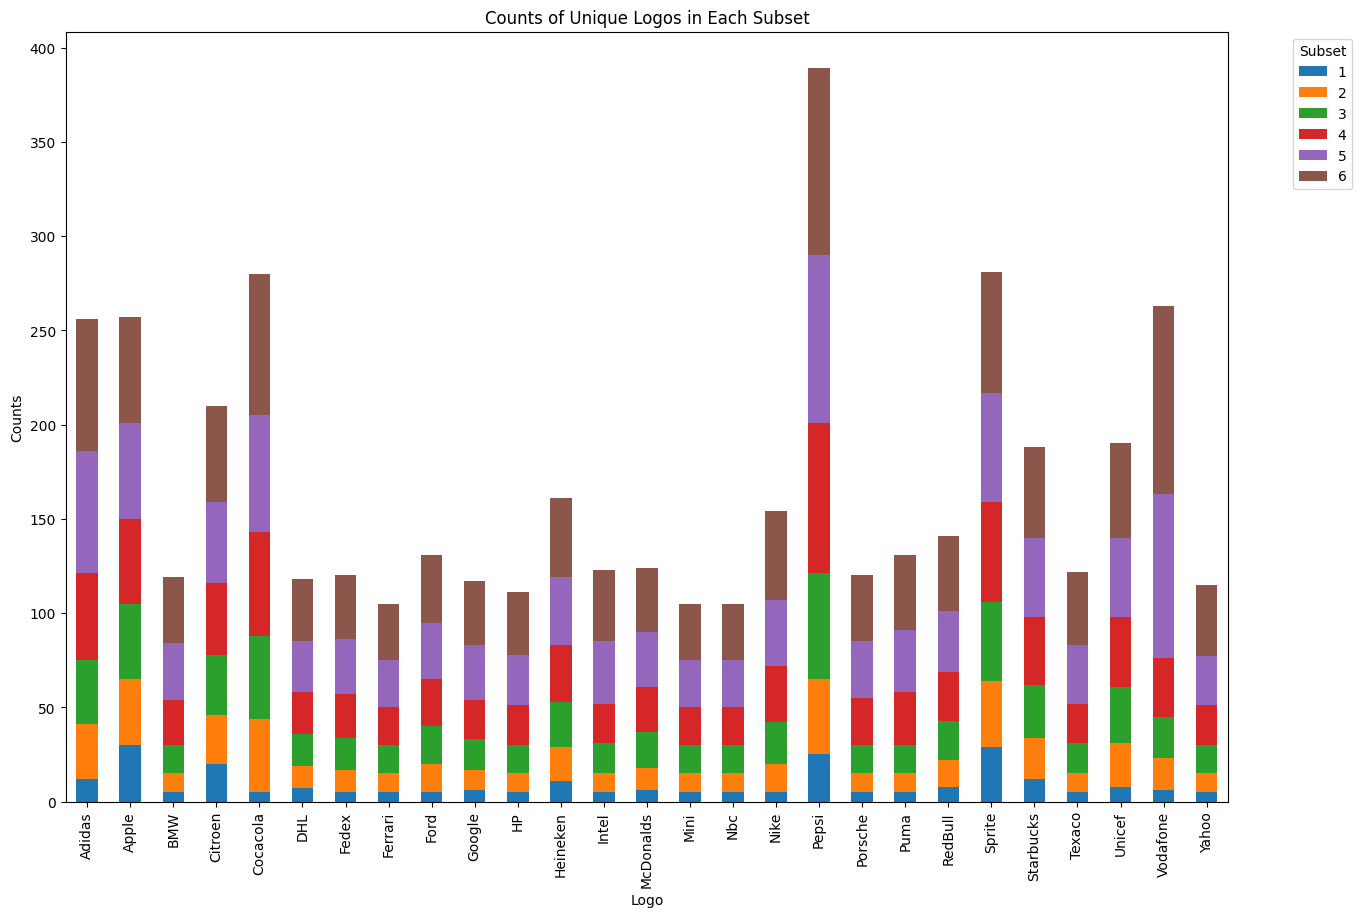

In [3]:
groupedDF = annotationDF.groupby(['logo', 'subset']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 10))
groupedDF.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Counts of Unique Logos in Each Subset')
plt.xlabel('Logo')
plt.ylabel('Counts')
plt.legend(title='Subset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Before Preprocessing

In [4]:
images_dir = "/Users/lejohntanjunyen/Documents/Pattern_Recognition/Pattern_Recognition/data/flickr_logos_27_dataset_images"
sample_images = []
sample_image_file = []

for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    sample_images.append(img)
    sample_image_file.append(image)

# Display the number of images and labels
print("Total images: {}".format(len(sample_images)))
print("Total labels: {}".format(len(sample_image_file)))

Total images: 1079
Total labels: 1079


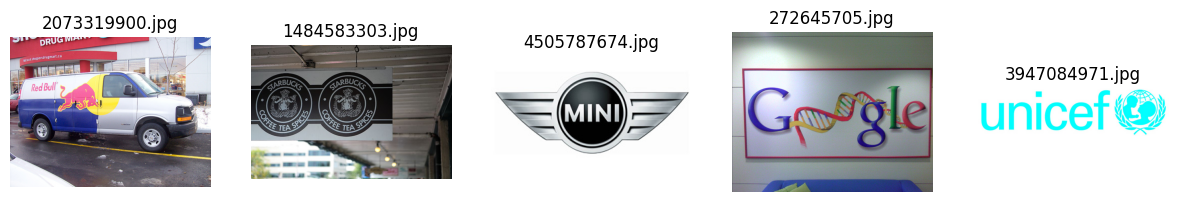

In [5]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample_images)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample_images[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image_file[index])
    plt.axis('off')
plt.show()

### After Cropping

In [6]:
# Initialize lists to hold the cropped images and their labels
sample2 = []
sample_image2 = []

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    
    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]
        
        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']
            cropped_img = img[y1:y2, x1:x2]
            
            sample2.append(cropped_img)
            sample_image2.append(logo)

# Display the number of images and labels
print("Total images: {}".format(len(sample2)))
print("Total labels: {}".format(len(sample_image2)))

Total images: 4536
Total labels: 4536


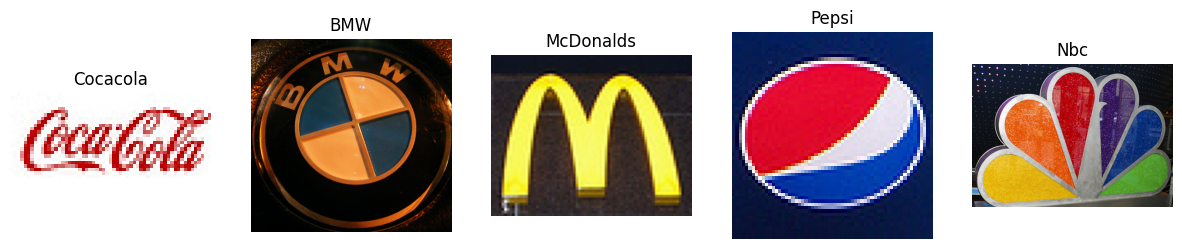

In [7]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample2)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample2[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image2[index])
    plt.axis('off')
plt.show()

### After Cropping Adding PreProcessing

In [9]:
# Initialize lists to hold the cropped images and their labels
X = []
y = []

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing functions
def preprocess_image(img):
    try:
        # Calculate padding to make the image square
        h, w = img.shape[:2]
        top, bottom, left, right = 0, 0, 0, 0
        if h > w:
            diff = h - w
            left = diff // 2
            right = diff - left
        else:
            diff = w - h
            top = diff // 2
            bottom = diff - top

        # Apply padding
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Resize to a fixed size (e.g., 224x224)
        img = cv2.resize(img, (224, 224))

        # Normalize pixel values to range [0, 1]
        img = img / 255.0

        return img
    
    except cv2.error as e:
        print(f"Error resizing image: {e}")
        return None

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)

    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]

        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']

            if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
                print(f"Invalid coordinates for image {image}: ({x1}, {y1}, {x2}, {y2})")
                continue

            cropped_img = img[y1:y2, x1:x2]

            if cropped_img.size == 0:
                print(f"Cropped image: {image} is empty for coordinates: ({x1}, {y1}, {x2}, {y2})")
                continue

            processed_img = preprocess_image(cropped_img)
            if processed_img is None:
                continue

            try:
                processed_img2 = np.expand_dims(processed_img, axis=0)

                aug_iter = datagen.flow(processed_img2, batch_size=1)
                aug_images = [next(aug_iter)[0].astype(np.float32)]

                X.append(processed_img)
                y.append(logo)

                for aug_img in aug_images:
                    X.append(aug_img)
                    y.append(logo)

            except cv2.error as e:
                print(f"OpenCV error: {e} for image {image}, with coordinates: ({x1}, {y1}, {x2}, {y2})")

try:
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
except ValueError as e:
    print(f"Error converting lists to arrays: {e}")

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))

Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Total images: 9062
Total labels: 9062


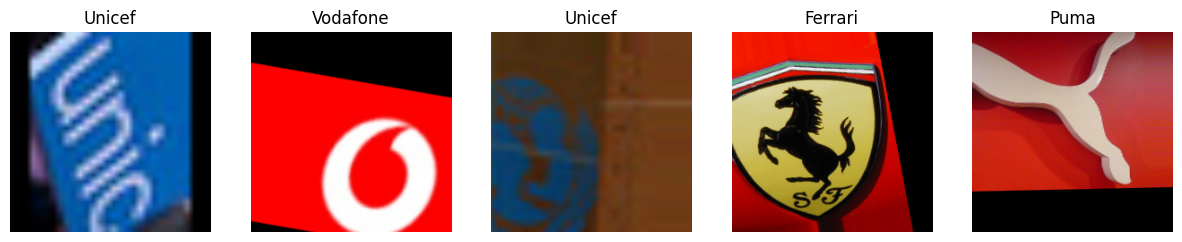

In [10]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB))
    plt.title(y[index])
    plt.axis('off')
plt.show()

## Split Train Test Data

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Validation images: {}".format(len(X_val)))
print("Testing images: {}".format(len(X_test)))

Total images: 9062
Total labels: 9062
Training images: 5436
Validation images: 1813
Testing images: 1813
